<a href="https://colab.research.google.com/github/GaoangLiu/AA_ipynb/blob/master/Deal_with_imbalanced_data_with_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!curl -o creditcard.csv ali.140714.xyz:8000/creditcard.csv
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  143M  100  143M    0     0  3772k      0  0:00:39  0:00:39 --:--:-- 3995k
creditcard.csv	cycle.csv  data.zip  sample_data


In [0]:
import pandas as pd 
import numpy as np
import xgboost

import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MultiLabelBinarizer
import sklearn.metrics
from lightgbm import LGBMRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from mlxtend.regressor import StackingCVRegressor

In [60]:
train = pd.read_csv('creditcard.csv')
train.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [0]:
from sklearn.preprocessing import StandardScaler

features = train
features['normal_amount'] = StandardScaler().fit_transform(train['Amount'].values.reshape(-1, 1))
labels = features.Class 
features.drop(columns=['Time', 'Amount', 'Class'], inplace=True)

In [28]:
%%time
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = xgboost.XGBClassifier()
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(features, labels, random_state=0)
model.fit(X_train, y_train)

def scores(labels, preds):
    print("Accuracy score", accuracy_score(labels, preds))
    print("Recall score", recall_score(labels, preds))
    print("f1 score", f1_score(labels, preds))        

CPU times: user 51.3 s, sys: 81.4 ms, total: 51.3 s
Wall time: 51.7 s


In [29]:
y_preds = model.predict(X_val)
print("== xgboost model, before using SMOTE: == ")
scores(y_val, y_preds)

Before using SMOTE: 
Accuracy score 0.9995084407741356
Recall score 0.775
f1 score 0.8416289592760181


## Over-sampling with SMOTE

In [66]:
from imblearn.over_sampling import SMOTE

normal = train[train.Class == 0].sample(50_000)
fraud = train[train.Class == 1].sample(492)
features = pd.concat([normal, fraud])
features['normal_amount'] = StandardScaler().fit_transform(features['Amount'].values.reshape(-1, 1))
labels = features.Class 
features.drop(columns=['Time', 'Amount', 'Class'], inplace=True)

smote = SMOTE()
X, y = smote.fit_resample(features, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [67]:
print("Length of y is now", len(y))
from collections import Counter
c = Counter(y)
print(" Number of 1 is ", c[1])
print(" Number of 0 is ", c[0])

Length of y is now 20000
 Number of 1 is  10000
 Number of 0 is  10000


Run model and see the scores, results
1. `accuracy_score` slightly degrades, from 0.99951 to 0.99629
2. `recall_score` improved from 0.775 to 0.85246
3. `f1_score` improved from 0.84163 to 0.9163

In [68]:
%%time
model = xgboost.XGBClassifier()
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(features, labels, random_state=0)
model.fit(X_train, y_train)

CPU times: user 1.54 s, sys: 3.93 ms, total: 1.55 s
Wall time: 1.56 s


In [69]:
y_preds = model.predict(X_val)
print("== xgboost model, after using SMOTE: == ")
scores(y_val, y_preds)

== xgboost model, after using SMOTE: == 
Accuracy score 0.9927563858177659
Recall score 0.8728813559322034
f1 score 0.9155555555555556


## Maximum `recall score`
We also found that the number of the majority dominates the total number of samples, and different number of majority yields different results on `f1_score`, and `recall_score`. 

Since we are predicting fraud credit card, we're more concerned about the `recall score`. Thus, we will search the best number of majority to maximum `recall_score`.

In [127]:
def _recall_score(n = 10000):
    normal = train[train.Class == 0].sample(n, random_state=0)
    fraud = train[train.Class == 1].sample(492)
    features = pd.concat([normal, fraud])
    features['normal_amount'] = StandardScaler().fit_transform(features['Amount'].values.reshape(-1, 1))
    labels = features.Class 
    features.drop(columns=['Time', 'Amount', 'Class'], inplace=True)

    smote = SMOTE(random_state=0)
    X, y = smote.fit_resample(features, labels)

    model = xgboost.XGBClassifier()
    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(features, labels, random_state=0)
    model.fit(X_train, y_train)

    y_preds = model.predict(X_val)
    # print("== xgboost model, after using SMOTE: == ")
    # scores(y_val, y_preds)

    return recall_score(y_val, y_preds)

_recall_score(5000)

0.7766990291262136

In [0]:
import warnings
warnings.filterwarnings('ignore')

ns = [i * 50 for i in range(5, 100)]
rc = []
for n in ns:
    # print("==" * 80)
    # print(f"Current number of majority is {n}")
    rc.append(_recall_score(n))


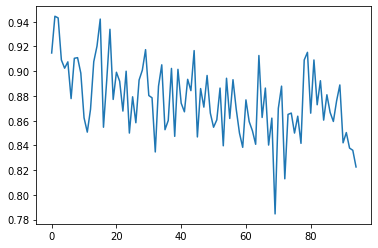

In [123]:
plt.plot(rc)

## Conclusions
After rounds of experiments, we found that there is no such thing as **best number** of majority to maximum the `recall_score`, because even with the same number of majority, the `recall_score` may vary.

The reason might be that the `SMOTE().fit_transform()` method faked different data at each run, this is something we can not control. 

Good news is, when the number of majority is close to the number of minority, we tend to get good scores on `recall`, but bad scores on `accuracy`.

In [152]:
df = pd.concat([train[train.Class==0].sample(100), train[train.Class==1].sample(30)])
df = df[['Amount', 'Class']]
df

,Amount,Class
224565,24.19,0
100741,2.00,0
141183,6.05,0
41011,1.79,0
107211,45.39,0
...,...,...
230076,0.77,1
204503,84.28,1
192529,1.00,1
275992,634.30,1


In [154]:
smote = SMOTE(random_state=20)
X, y = smote.fit_resample(df, df.Class)
X, y

(array([[2.41900000e+01, 0.00000000e+00],
        [2.00000000e+00, 0.00000000e+00],
        [6.05000000e+00, 0.00000000e+00],
        [1.79000000e+00, 0.00000000e+00],
        [4.53900000e+01, 0.00000000e+00],
        [1.29000000e+00, 0.00000000e+00],
        [6.67900000e+01, 0.00000000e+00],
        [3.91300000e+01, 0.00000000e+00],
        [1.20400000e+02, 0.00000000e+00],
        [2.68300000e+01, 0.00000000e+00],
        [1.12000000e+02, 0.00000000e+00],
        [9.99000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00],
        [1.39900000e+01, 0.00000000e+00],
        [5.80000000e+01, 0.00000000e+00],
        [7.50000000e+01, 0.00000000e+00],
        [8.00000000e+00, 0.00000000e+00],
        [1.18500000e+01, 0.00000000e+00],
        [7.13800000e+01, 0.00000000e+00],
        [3.09800000e+01, 0.00000000e+00],
        [2.49900000e+01, 0.00000000e+00],
        [1.21160000e+02, 0.00000000e+00],
        [2.09030000e+02, 0.00000000e+00],
        [1.09000000e+01, 0.0000000